En el presente Notebook se evaluará el modelo de Prophet con respecto a los datos diarios de Demanda Nacional de Energía, realizando ajustes en el mismo con el fin de obtener unas métricas mejores.

In [51]:
import numpy as np
import pandas as pd
from prophet import Prophet

from datetime import datetime

import json
from pandas import Timestamp

import requests
from pprint import pprint

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, SimpleRNN, Dropout

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.preprocessing import MinMaxScaler
import itertools
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [2]:
demanda_nacional=pd.read_csv("demanda_nacional.csv")
demanda_nacional

Fecha  Energia Consumida Mw/h
0     2011-01-01                  605.99
1     2011-01-02                  641.86
2     2011-01-03                  801.30
3     2011-01-04                  833.25
4     2011-01-05                  803.48
...          ...                     ...
4611  2023-08-17                  705.51
4612  2023-08-18                  706.09
4613  2023-08-19                  664.26
4614  2023-08-20                  648.87
4615  2023-08-21                  741.41

[4616 rows x 2 columns]

In [3]:
demanda_nacional["Fecha"] = demanda_nacional["Fecha"].apply(lambda x : datetime.strptime(x,"%Y-%m-%d"))


In [4]:
train_demanda = demanda_nacional[:4383]

test_demanda = demanda_nacional[4383:]

train_demanda = train_demanda.rename(columns = {"Fecha":"ds", "Energia Consumida Mw/h":"y"})

In [5]:
# Inicializamos un objeto Prophet y lo entrenamos con el dataframe.

m = Prophet()
m.fit(train_demanda)

20:31:12 - cmdstanpy - INFO - Chain [1] start processing
20:31:13 - cmdstanpy - INFO - Chain [1] done processing


In [6]:
# Extendemos el dataframe para un número concreto de días futuros

future = m.make_future_dataframe(periods = 233)

future.tail()

ds
4611 2023-08-17
4612 2023-08-18
4613 2023-08-19
4614 2023-08-20
4615 2023-08-21

In [7]:
# EL método de predicción asigna un yhat a cada una de las fechas
#Este método devuelve un dataframe con la predicción futura y la incertidumbre de dichos valores

forecast = m.predict(future)

forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

ds        yhat  yhat_lower  yhat_upper
4611 2023-08-17  721.283891  677.605099  762.827350
4612 2023-08-18  714.410648  671.015316  758.454291
4613 2023-08-19  644.567535  603.719023  686.705141
4614 2023-08-20  596.330486  549.141018  641.352064
4615 2023-08-21  705.572844  658.689747  748.504176

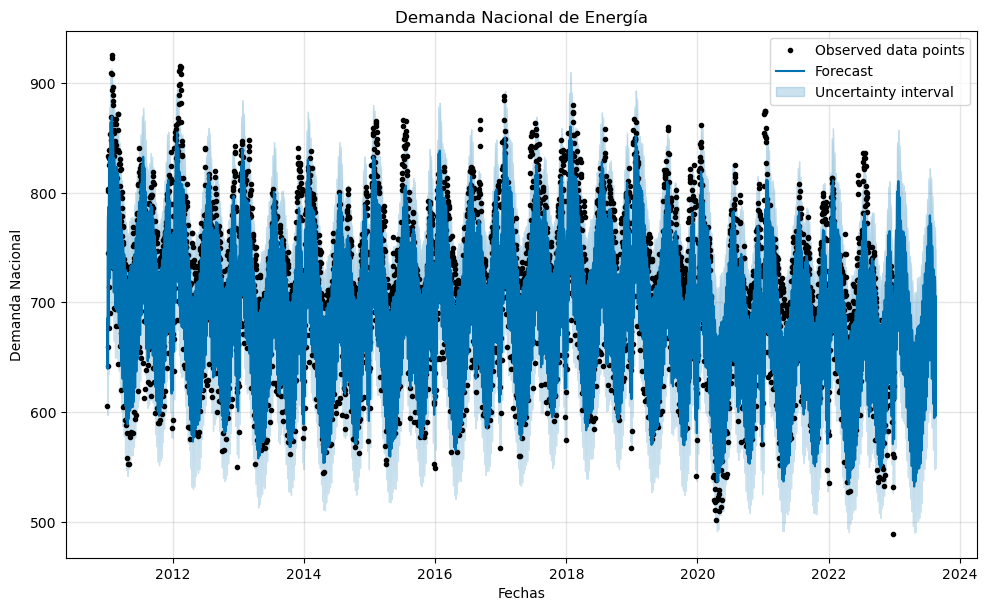

In [8]:
# Graficamos las predicciones

fig1 = m.plot(forecast)

plt.xlabel("Fechas")
plt.ylabel("Demanda Nacional")
plt.title("Demanda Nacional de Energía")
plt.legend()
plt.show()

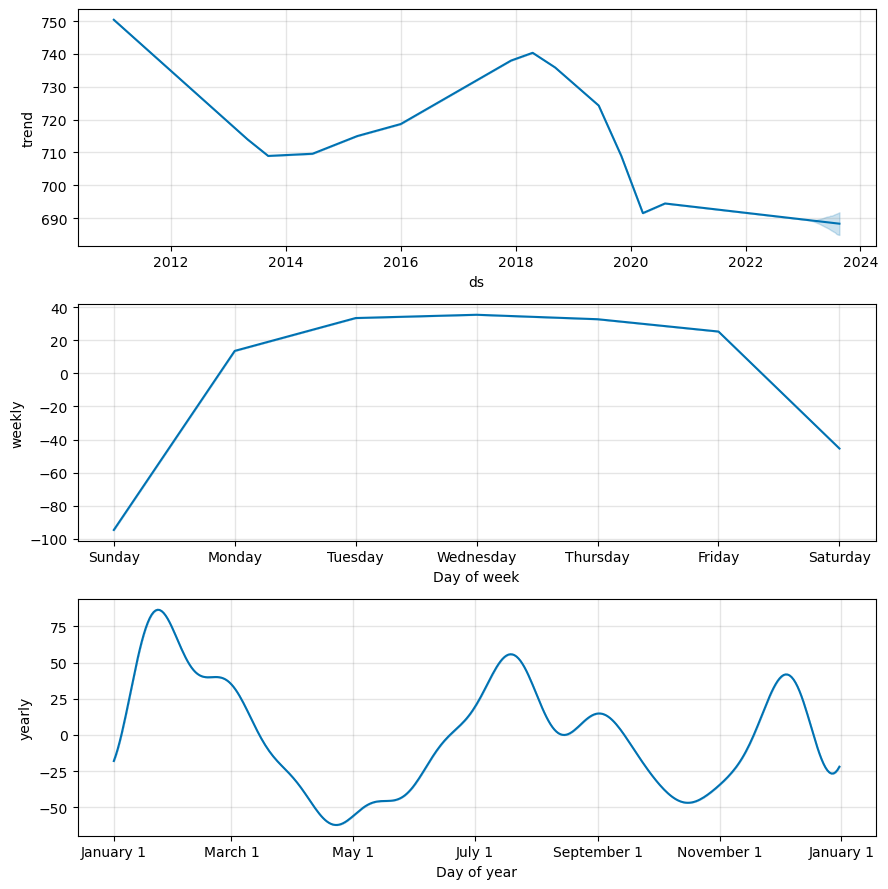

In [9]:
# Se puede ver la predicción por componentes

fig2 = m.plot_components(forecast)

In [10]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [11]:
comparacion_modelos = forecast[["ds", "yhat"]][-233:]

In [12]:
comparacion_modelos = comparacion_modelos.rename(columns = {"ds":"Fechas", "yhat":"Prophet inicial"})

In [13]:
comparacion_modelos["test"]=demanda_nacional["Energia Consumida Mw/h"][-233:]

In [14]:
r2_score(comparacion_modelos['test'], comparacion_modelos['Prophet inicial'])

0.757839394819943

## Tuneado de Prophet

### Cambio de tendencias

Puntos de cambio de tendencia. Por defecto, prophet los selecciona para el 80% de los datos temporales para evitar un sobreajuste de las fluctuaciones. Esto se puede cambiar, por ejemplo al 90% para ver así si mejora el modelo.

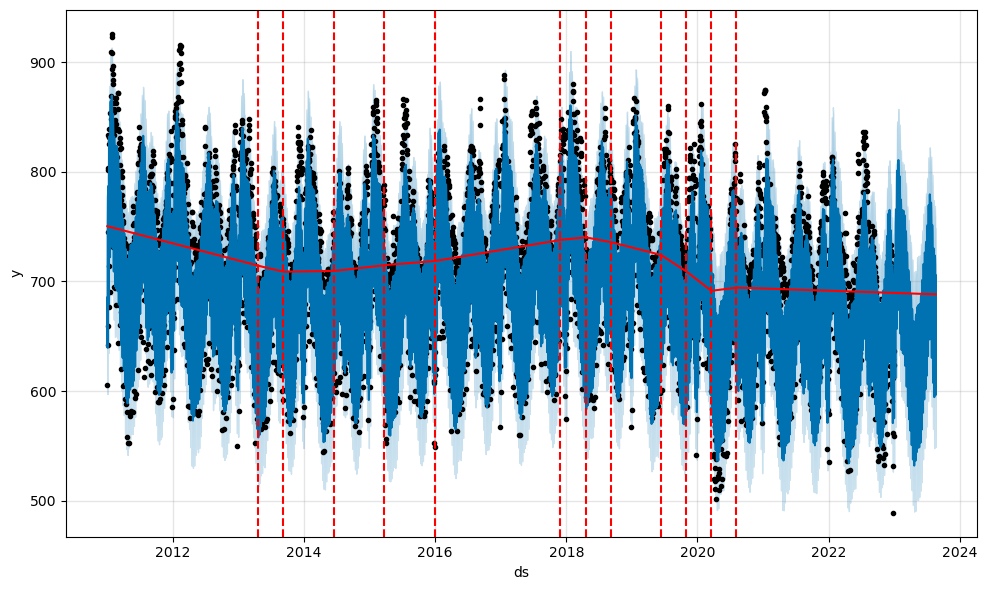

In [15]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [22]:
m = Prophet(changepoint_range=0.9)
m.fit(train_demanda)
future = m.make_future_dataframe(periods = 233)
forecast = m.predict(future)

forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

21:14:50 - cmdstanpy - INFO - Chain [1] start processing
21:14:51 - cmdstanpy - INFO - Chain [1] done processing


ds        yhat  yhat_lower  yhat_upper
4611 2023-08-17  687.448130  644.954614  734.011635
4612 2023-08-18  680.500589  637.386070  720.162643
4613 2023-08-19  610.583456  565.789554  655.973479
4614 2023-08-20  562.245053  513.679618  606.261555
4615 2023-08-21  671.415028  626.784757  716.085789

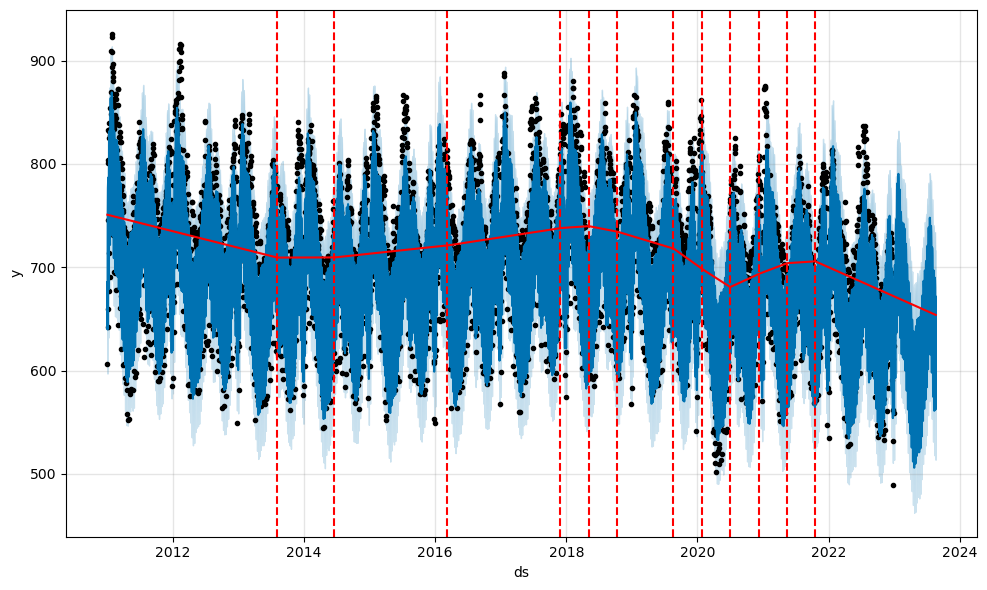

In [23]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [24]:
r2_score(comparacion_modelos['test'], forecast["yhat"][-233:])

0.8063454782832782

Podemos observar que mejoró un poco. Si ponemos 95% vemos que se reduce la precisión puesto que se realiza un sobreajuste de los datos.

In [25]:
m = Prophet(changepoint_prior_scale=0.95)
m.fit(train_demanda)
future = m.make_future_dataframe(periods = 233)
forecast = m.predict(future)
r2_score(comparacion_modelos['test'], forecast["yhat"][-233:])

21:15:46 - cmdstanpy - INFO - Chain [1] start processing
21:15:49 - cmdstanpy - INFO - Chain [1] done processing


0.7872929898652197

Nos quedaríamos por lo tanto con el 90 %
Por otro lado, se puede ajustar también la flexibilidad del modelo, utilizando la entrada changepoint_prior_scale, que por defecto se establece en 0.05. Cuanto mayor sea este parámetro, mayor flexibilidad presentará la tendencia.
En este caso se observa que reduciendo el valor a 0.005, el modelo mejora.

In [42]:
m = Prophet(changepoint_range=0.9, changepoint_prior_scale=0.005)
m.fit(train_demanda)
future = m.make_future_dataframe(periods = 233)
forecast = m.predict(future)
r2_score(comparacion_modelos['test'], forecast["yhat"][-233:])

21:20:57 - cmdstanpy - INFO - Chain [1] start processing
21:20:58 - cmdstanpy - INFO - Chain [1] done processing


0.8152021333930451

### La estacionalidad

EL modelo de prophet puede ser modificado también de cara a tener en cuenta períodos vacacionales u otros eventos. La estacionalidad se determina utilizando la suma parcial de Fourier, en la cual se introduce un parámetro que determina la rapidez del cambio. Por defecto, se establece una estacionalidad anual de 10. Se hace una prueba aumentando a 20, aunque hay que tener en cuenta que al aumentar este elemento, también se puede llegar a un sobreentrenamiento del modelo.

In [46]:
m = Prophet(changepoint_range=0.9, 
            changepoint_prior_scale=0.005,
            yearly_seasonality= 20)
m.fit(train_demanda)
future = m.make_future_dataframe(periods = 233)
forecast = m.predict(future)
r2_score(comparacion_modelos['test'], forecast["yhat"][-233:])

21:29:25 - cmdstanpy - INFO - Chain [1] start processing
21:29:26 - cmdstanpy - INFO - Chain [1] done processing


0.7948275766435924

### Tuneado de hiperparámetros.

Una vez evaluados estos parámetros, se procede a hacer un tuneado de los hiperparámetros del modelo. Se presentarán todas las combinaciones en un DataFrame, así como el r2 correspondiente a cada uno de los modelos resultantes.

In [65]:
param_grid = {"changepoint_range" : [0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
              "changepoint_prior_scale": [0.001, 0.01, 0.05, 0.1, 0.5],
              "seasonality_prior_scale": [0.01, 0.1, 1.0, 5, 10, 15, 20], 
              "yearly_seasonality": [5,10,15,20]}

# Se generan todas las combinaciones de los parámetros
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
r2_list = list()

# Se utiliza cross validation para evaluar todos los parámetros

for params in all_params:
    m = Prophet(**params).fit(train_demanda)  # Fit model with given params
    future = m.make_future_dataframe(periods=233)
    forecast = m.predict(future)
    r2 = r2_score(comparacion_modelos['test'], forecast["yhat"][-233:])
    r2_list.append(r2)
    
# Buscamos los mejores parámetros
tuning_results = pd.DataFrame(all_params)
tuning_results['r2'] = r2_list
tuning_results

17:23:37 - cmdstanpy - INFO - Chain [1] start processing
17:23:37 - cmdstanpy - INFO - Chain [1] done processing
17:23:40 - cmdstanpy - INFO - Chain [1] start processing
17:23:41 - cmdstanpy - INFO - Chain [1] done processing
17:23:44 - cmdstanpy - INFO - Chain [1] start processing
17:23:45 - cmdstanpy - INFO - Chain [1] done processing
17:23:49 - cmdstanpy - INFO - Chain [1] start processing
17:23:49 - cmdstanpy - INFO - Chain [1] done processing
17:23:53 - cmdstanpy - INFO - Chain [1] start processing
17:23:54 - cmdstanpy - INFO - Chain [1] done processing
17:23:57 - cmdstanpy - INFO - Chain [1] start processing
17:23:58 - cmdstanpy - INFO - Chain [1] done processing
17:24:02 - cmdstanpy - INFO - Chain [1] start processing
17:24:03 - cmdstanpy - INFO - Chain [1] done processing
17:24:07 - cmdstanpy - INFO - Chain [1] start processing
17:24:08 - cmdstanpy - INFO - Chain [1] done processing
17:24:11 - cmdstanpy - INFO - Chain [1] start processing
17:24:12 - cmdstanpy - INFO - Chain [1]

17:27:04 - cmdstanpy - INFO - Chain [1] done processing
17:27:06 - cmdstanpy - INFO - Chain [1] start processing
17:27:06 - cmdstanpy - INFO - Chain [1] done processing
17:27:08 - cmdstanpy - INFO - Chain [1] start processing
17:27:09 - cmdstanpy - INFO - Chain [1] done processing
17:27:11 - cmdstanpy - INFO - Chain [1] start processing
17:27:12 - cmdstanpy - INFO - Chain [1] done processing
17:27:13 - cmdstanpy - INFO - Chain [1] start processing
17:27:14 - cmdstanpy - INFO - Chain [1] done processing
17:27:16 - cmdstanpy - INFO - Chain [1] start processing
17:27:17 - cmdstanpy - INFO - Chain [1] done processing
17:27:19 - cmdstanpy - INFO - Chain [1] start processing
17:27:20 - cmdstanpy - INFO - Chain [1] done processing
17:27:22 - cmdstanpy - INFO - Chain [1] start processing
17:27:23 - cmdstanpy - INFO - Chain [1] done processing
17:27:24 - cmdstanpy - INFO - Chain [1] start processing
17:27:25 - cmdstanpy - INFO - Chain [1] done processing
17:27:26 - cmdstanpy - INFO - Chain [1] 

17:30:47 - cmdstanpy - INFO - Chain [1] done processing
17:30:49 - cmdstanpy - INFO - Chain [1] start processing
17:30:50 - cmdstanpy - INFO - Chain [1] done processing
17:30:52 - cmdstanpy - INFO - Chain [1] start processing
17:30:52 - cmdstanpy - INFO - Chain [1] done processing
17:30:54 - cmdstanpy - INFO - Chain [1] start processing
17:30:54 - cmdstanpy - INFO - Chain [1] done processing
17:30:56 - cmdstanpy - INFO - Chain [1] start processing
17:30:56 - cmdstanpy - INFO - Chain [1] done processing
17:30:58 - cmdstanpy - INFO - Chain [1] start processing
17:30:59 - cmdstanpy - INFO - Chain [1] done processing
17:31:01 - cmdstanpy - INFO - Chain [1] start processing
17:31:02 - cmdstanpy - INFO - Chain [1] done processing
17:31:03 - cmdstanpy - INFO - Chain [1] start processing
17:31:04 - cmdstanpy - INFO - Chain [1] done processing
17:31:05 - cmdstanpy - INFO - Chain [1] start processing
17:31:06 - cmdstanpy - INFO - Chain [1] done processing
17:31:08 - cmdstanpy - INFO - Chain [1] 

17:33:51 - cmdstanpy - INFO - Chain [1] done processing
17:33:53 - cmdstanpy - INFO - Chain [1] start processing
17:33:54 - cmdstanpy - INFO - Chain [1] done processing
17:33:56 - cmdstanpy - INFO - Chain [1] start processing
17:33:57 - cmdstanpy - INFO - Chain [1] done processing
17:33:59 - cmdstanpy - INFO - Chain [1] start processing
17:33:59 - cmdstanpy - INFO - Chain [1] done processing
17:34:01 - cmdstanpy - INFO - Chain [1] start processing
17:34:02 - cmdstanpy - INFO - Chain [1] done processing
17:34:04 - cmdstanpy - INFO - Chain [1] start processing
17:34:05 - cmdstanpy - INFO - Chain [1] done processing
17:34:07 - cmdstanpy - INFO - Chain [1] start processing
17:34:08 - cmdstanpy - INFO - Chain [1] done processing
17:34:10 - cmdstanpy - INFO - Chain [1] start processing
17:34:11 - cmdstanpy - INFO - Chain [1] done processing
17:34:14 - cmdstanpy - INFO - Chain [1] start processing
17:34:15 - cmdstanpy - INFO - Chain [1] done processing
17:34:17 - cmdstanpy - INFO - Chain [1] 

17:37:46 - cmdstanpy - INFO - Chain [1] done processing
17:37:47 - cmdstanpy - INFO - Chain [1] start processing
17:37:47 - cmdstanpy - INFO - Chain [1] done processing
17:37:49 - cmdstanpy - INFO - Chain [1] start processing
17:37:50 - cmdstanpy - INFO - Chain [1] done processing
17:37:51 - cmdstanpy - INFO - Chain [1] start processing
17:37:52 - cmdstanpy - INFO - Chain [1] done processing
17:37:54 - cmdstanpy - INFO - Chain [1] start processing
17:37:55 - cmdstanpy - INFO - Chain [1] done processing
17:37:57 - cmdstanpy - INFO - Chain [1] start processing
17:37:57 - cmdstanpy - INFO - Chain [1] done processing
17:37:59 - cmdstanpy - INFO - Chain [1] start processing
17:37:59 - cmdstanpy - INFO - Chain [1] done processing
17:38:01 - cmdstanpy - INFO - Chain [1] start processing
17:38:01 - cmdstanpy - INFO - Chain [1] done processing
17:38:03 - cmdstanpy - INFO - Chain [1] start processing
17:38:04 - cmdstanpy - INFO - Chain [1] done processing
17:38:06 - cmdstanpy - INFO - Chain [1] 

17:41:03 - cmdstanpy - INFO - Chain [1] done processing
17:41:05 - cmdstanpy - INFO - Chain [1] start processing
17:41:06 - cmdstanpy - INFO - Chain [1] done processing
17:41:09 - cmdstanpy - INFO - Chain [1] start processing
17:41:11 - cmdstanpy - INFO - Chain [1] done processing
17:41:13 - cmdstanpy - INFO - Chain [1] start processing
17:41:15 - cmdstanpy - INFO - Chain [1] done processing
17:41:17 - cmdstanpy - INFO - Chain [1] start processing
17:41:18 - cmdstanpy - INFO - Chain [1] done processing
17:41:20 - cmdstanpy - INFO - Chain [1] start processing
17:41:21 - cmdstanpy - INFO - Chain [1] done processing
17:41:23 - cmdstanpy - INFO - Chain [1] start processing
17:41:26 - cmdstanpy - INFO - Chain [1] done processing
17:41:28 - cmdstanpy - INFO - Chain [1] start processing
17:41:30 - cmdstanpy - INFO - Chain [1] done processing
17:41:32 - cmdstanpy - INFO - Chain [1] start processing
17:41:33 - cmdstanpy - INFO - Chain [1] done processing
17:41:35 - cmdstanpy - INFO - Chain [1] 

17:45:21 - cmdstanpy - INFO - Chain [1] done processing
17:45:23 - cmdstanpy - INFO - Chain [1] start processing
17:45:24 - cmdstanpy - INFO - Chain [1] done processing
17:45:26 - cmdstanpy - INFO - Chain [1] start processing
17:45:27 - cmdstanpy - INFO - Chain [1] done processing
17:45:28 - cmdstanpy - INFO - Chain [1] start processing
17:45:29 - cmdstanpy - INFO - Chain [1] done processing
17:45:31 - cmdstanpy - INFO - Chain [1] start processing
17:45:31 - cmdstanpy - INFO - Chain [1] done processing
17:45:33 - cmdstanpy - INFO - Chain [1] start processing
17:45:34 - cmdstanpy - INFO - Chain [1] done processing
17:45:36 - cmdstanpy - INFO - Chain [1] start processing
17:45:36 - cmdstanpy - INFO - Chain [1] done processing
17:45:38 - cmdstanpy - INFO - Chain [1] start processing
17:45:38 - cmdstanpy - INFO - Chain [1] done processing
17:45:41 - cmdstanpy - INFO - Chain [1] start processing
17:45:41 - cmdstanpy - INFO - Chain [1] done processing
17:45:43 - cmdstanpy - INFO - Chain [1] 

17:48:50 - cmdstanpy - INFO - Chain [1] done processing
17:48:52 - cmdstanpy - INFO - Chain [1] start processing
17:48:55 - cmdstanpy - INFO - Chain [1] done processing
17:48:57 - cmdstanpy - INFO - Chain [1] start processing
17:48:58 - cmdstanpy - INFO - Chain [1] done processing
17:49:00 - cmdstanpy - INFO - Chain [1] start processing
17:49:02 - cmdstanpy - INFO - Chain [1] done processing
17:49:04 - cmdstanpy - INFO - Chain [1] start processing
17:49:05 - cmdstanpy - INFO - Chain [1] done processing
17:49:08 - cmdstanpy - INFO - Chain [1] start processing
17:49:11 - cmdstanpy - INFO - Chain [1] done processing
17:49:12 - cmdstanpy - INFO - Chain [1] start processing
17:49:13 - cmdstanpy - INFO - Chain [1] done processing
17:49:15 - cmdstanpy - INFO - Chain [1] start processing
17:49:16 - cmdstanpy - INFO - Chain [1] done processing
17:49:18 - cmdstanpy - INFO - Chain [1] start processing
17:49:20 - cmdstanpy - INFO - Chain [1] done processing
17:49:22 - cmdstanpy - INFO - Chain [1] 

17:52:57 - cmdstanpy - INFO - Chain [1] done processing
17:52:59 - cmdstanpy - INFO - Chain [1] start processing
17:52:59 - cmdstanpy - INFO - Chain [1] done processing
17:53:01 - cmdstanpy - INFO - Chain [1] start processing
17:53:01 - cmdstanpy - INFO - Chain [1] done processing
17:53:03 - cmdstanpy - INFO - Chain [1] start processing
17:53:04 - cmdstanpy - INFO - Chain [1] done processing
17:53:06 - cmdstanpy - INFO - Chain [1] start processing
17:53:06 - cmdstanpy - INFO - Chain [1] done processing
17:53:08 - cmdstanpy - INFO - Chain [1] start processing
17:53:09 - cmdstanpy - INFO - Chain [1] done processing
17:53:11 - cmdstanpy - INFO - Chain [1] start processing
17:53:11 - cmdstanpy - INFO - Chain [1] done processing
17:53:13 - cmdstanpy - INFO - Chain [1] start processing
17:53:14 - cmdstanpy - INFO - Chain [1] done processing
17:53:16 - cmdstanpy - INFO - Chain [1] start processing
17:53:17 - cmdstanpy - INFO - Chain [1] done processing
17:53:18 - cmdstanpy - INFO - Chain [1] 

17:56:36 - cmdstanpy - INFO - Chain [1] done processing
17:56:38 - cmdstanpy - INFO - Chain [1] start processing
17:56:39 - cmdstanpy - INFO - Chain [1] done processing
17:56:41 - cmdstanpy - INFO - Chain [1] start processing
17:56:43 - cmdstanpy - INFO - Chain [1] done processing
17:56:45 - cmdstanpy - INFO - Chain [1] start processing
17:56:47 - cmdstanpy - INFO - Chain [1] done processing
17:56:49 - cmdstanpy - INFO - Chain [1] start processing
17:56:50 - cmdstanpy - INFO - Chain [1] done processing
17:56:52 - cmdstanpy - INFO - Chain [1] start processing
17:56:54 - cmdstanpy - INFO - Chain [1] done processing
17:56:56 - cmdstanpy - INFO - Chain [1] start processing
17:56:58 - cmdstanpy - INFO - Chain [1] done processing
17:57:00 - cmdstanpy - INFO - Chain [1] start processing
17:57:02 - cmdstanpy - INFO - Chain [1] done processing
17:57:03 - cmdstanpy - INFO - Chain [1] start processing
17:57:04 - cmdstanpy - INFO - Chain [1] done processing
17:57:06 - cmdstanpy - INFO - Chain [1] 

18:00:32 - cmdstanpy - INFO - Chain [1] done processing
18:00:34 - cmdstanpy - INFO - Chain [1] start processing
18:00:34 - cmdstanpy - INFO - Chain [1] done processing
18:00:37 - cmdstanpy - INFO - Chain [1] start processing
18:00:37 - cmdstanpy - INFO - Chain [1] done processing
18:00:39 - cmdstanpy - INFO - Chain [1] start processing
18:00:40 - cmdstanpy - INFO - Chain [1] done processing
18:00:41 - cmdstanpy - INFO - Chain [1] start processing
18:00:42 - cmdstanpy - INFO - Chain [1] done processing
18:00:44 - cmdstanpy - INFO - Chain [1] start processing
18:00:44 - cmdstanpy - INFO - Chain [1] done processing
18:00:47 - cmdstanpy - INFO - Chain [1] start processing
18:00:47 - cmdstanpy - INFO - Chain [1] done processing
18:00:49 - cmdstanpy - INFO - Chain [1] start processing
18:00:49 - cmdstanpy - INFO - Chain [1] done processing
18:00:51 - cmdstanpy - INFO - Chain [1] start processing
18:00:52 - cmdstanpy - INFO - Chain [1] done processing
18:00:54 - cmdstanpy - INFO - Chain [1] 

18:04:09 - cmdstanpy - INFO - Chain [1] done processing
18:04:12 - cmdstanpy - INFO - Chain [1] start processing
18:04:15 - cmdstanpy - INFO - Chain [1] done processing
18:04:17 - cmdstanpy - INFO - Chain [1] start processing
18:04:18 - cmdstanpy - INFO - Chain [1] done processing
18:04:20 - cmdstanpy - INFO - Chain [1] start processing
18:04:21 - cmdstanpy - INFO - Chain [1] done processing
18:04:23 - cmdstanpy - INFO - Chain [1] start processing
18:04:24 - cmdstanpy - INFO - Chain [1] done processing
18:04:27 - cmdstanpy - INFO - Chain [1] start processing
18:04:28 - cmdstanpy - INFO - Chain [1] done processing
18:04:30 - cmdstanpy - INFO - Chain [1] start processing
18:04:30 - cmdstanpy - INFO - Chain [1] done processing
18:04:32 - cmdstanpy - INFO - Chain [1] start processing
18:04:33 - cmdstanpy - INFO - Chain [1] done processing
18:04:35 - cmdstanpy - INFO - Chain [1] start processing
18:04:37 - cmdstanpy - INFO - Chain [1] done processing
18:04:40 - cmdstanpy - INFO - Chain [1] 

changepoint_range  changepoint_prior_scale  seasonality_prior_scale  \
0                 0.70                    0.001                     0.01   
1                 0.70                    0.001                     0.01   
2                 0.70                    0.001                     0.01   
3                 0.70                    0.001                     0.01   
4                 0.70                    0.001                     0.10   
..                 ...                      ...                      ...   
835               0.95                    0.500                    15.00   
836               0.95                    0.500                    20.00   
837               0.95                    0.500                    20.00   
838               0.95                    0.500                    20.00   
839               0.95                    0.500                    20.00   

     yearly_seasonality        r2  
0                     5  0.716713  
1                    10  0.746943  
2                    15  0.742113  
3                    20  0.737734  
4                     5  0.720043  
..                  ...       ...  
835                  20 -0.326258  
836                   5 -0.493631  
837                  10 -0.291463  
838                  15 -0.325726  
839                  20 -0.315316  

[840 rows x 5 columns]

In [69]:
best_params = all_params[np.argmax(r2_list)]
print(best_params)

{'changepoint_range': 0.7, 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'yearly_seasonality': 10}


In [70]:
m = Prophet(changepoint_range=0.7, 
            changepoint_prior_scale=0.01,
            seasonality_prior_scale=15,
            yearly_seasonality=10)
m.fit(train_demanda)
future = m.make_future_dataframe(periods = 233)
forecast = m.predict(future)
r2_score(comparacion_modelos['test'], forecast["yhat"][-233:])

19:37:59 - cmdstanpy - INFO - Chain [1] start processing
19:37:59 - cmdstanpy - INFO - Chain [1] done processing


0.8188999187514973